In [1]:
import numpy as np
import geopandas as gpd
import xarray as xr
from matplotlib import pyplot as plt
import json
import random
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import contextily as cx

### Read the input data

In [2]:
gdf = gpd.GeoDataFrame.from_file("urban_forest.geojson").set_crs(4326)
gdf

,class,random_property1,random_property2,geometry
0,0,string,None,"POLYGON ((11.12123 46.06901, 11.12244 46.06901..."
1,0,None,string2,"POLYGON ((11.12260 46.06836, 11.12375 46.06836..."
2,0,None,None,"POLYGON ((11.12257 46.06743, 11.12380 46.06743..."
3,0,None,None,"POLYGON ((11.12408 46.07025, 11.12538 46.07025..."
4,0,None,None,"POLYGON ((11.12426 46.06951, 11.12561 46.06951..."
...,...,...,...,...
105,1,None,None,"POLYGON ((11.14366 46.13429, 11.14535 46.13429..."
106,1,None,None,"POLYGON ((11.15147 46.13359, 11.15323 46.13359..."
107,1,None,None,"POLYGON ((11.15297 46.13612, 11.15484 46.13612..."
108,1,None,None,POINT (11.12207 46.08432)


### Visualize input data

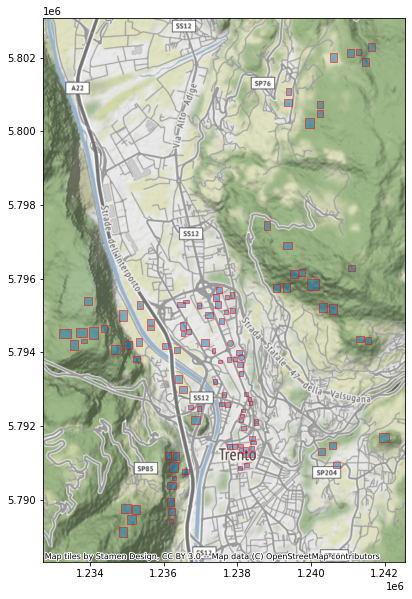

In [3]:
# Source https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
df_wm = gdf.to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='r')
cx.add_basemap(ax)

### Divide features into polygons and points (TODO: add handling of MultiPolygons)

In [4]:
points_gdf   = gpd.GeoDataFrame(columns=gdf.columns).set_crs(4326)
polygons_gdf = gpd.GeoDataFrame(columns=gdf.columns).set_crs(4326)

In [5]:
for idx, row in gdf.iterrows():
    if type(row.geometry) == Polygon:
        polygons_gdf = polygons_gdf.append(row,ignore_index=True)
    if type(row.geometry) == Point:
        points_gdf = points_gdf.append(row,ignore_index=True)

In [6]:
polygons_gdf = polygons_gdf.set_crs(4326)
polygons_gdf

,class,random_property1,random_property2,geometry
0,0,string,None,"POLYGON ((11.12123 46.06901, 11.12244 46.06901..."
1,0,None,string2,"POLYGON ((11.12260 46.06836, 11.12375 46.06836..."
2,0,None,None,"POLYGON ((11.12257 46.06743, 11.12380 46.06743..."
3,0,None,None,"POLYGON ((11.12408 46.07025, 11.12538 46.07025..."
4,0,None,None,"POLYGON ((11.12426 46.06951, 11.12561 46.06951..."
...,...,...,...,...
103,1,None,None,"POLYGON ((11.15020 46.13542, 11.15132 46.13542..."
104,1,None,None,"POLYGON ((11.14790 46.13499, 11.14966 46.13499..."
105,1,None,None,"POLYGON ((11.14366 46.13429, 11.14535 46.13429..."
106,1,None,None,"POLYGON ((11.15147 46.13359, 11.15323 46.13359..."


In [7]:
points_gdf = points_gdf.set_crs(4326)
points_gdf

,class,random_property1,random_property2,geometry
0,1,None,None,POINT (11.12207 46.08432)
1,1,None,None,POINT (11.11945 46.08664)


In [8]:
## Compute the total area of all the polygons
## We tranform first the points to an equal area projection
## Found this CRS in this discussion, can be changed https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
polygons_gdf_6933 = polygons_gdf.to_crs(6933)
                                        
gdf_areas = np.asarray([geom.area for geom in polygons_gdf_6933['geometry']])
tot_area = np.sum(gdf_areas)
tot_area

1643087.6613486067

In [9]:
# Depending on the max number of points we want to extract and the area of each polygon,
# we extract a proportional number of points for each polygon depending on its area
# Minimum number of points extracted from each geometry is 1.

max_points = 1000

# Check if the max number of points is greater than the number of geometries
features_count = len(points_gdf) + len(polygons_gdf)
if max_points < features_count:
    raise Exception("The maximum number of points must be >= the number of features of the provided geoJSON!\
 max_points = {} numb of features = {}".format(max_points,features_count))
    
# Compute how many points per area unit we will sample
# We need to subtract the number of points provided as input first

pts_per_unit = (max_points - len(points_gdf)) / tot_area
pts_per_unit

0.000607393034149417

In [10]:
pts_each_polygon = np.multiply(pts_per_unit,gdf_areas)
# Round the number of points to the closest integer
pts_each_polygon = np.floor(pts_each_polygon).astype(int) # or np.round
# Check if there are polygons which will have a single point
pts_each_polygon[pts_each_polygon==0] = 1
pts_each_polygon

array([ 4,  3,  4,  4,  4,  7,  4,  5,  3,  4,  3,  4,  2,  3,  3,  5,  4,
        2,  2,  3,  4,  4,  4,  4,  4,  4,  4,  5,  6,  3,  4,  1,  3,  7,
        3,  5,  8,  8,  4,  5,  6,  4,  5,  5, 10,  5, 10,  6, 12,  7,  6,
        8, 17,  7,  9, 12,  9, 16, 10, 24, 23, 10, 13,  4, 16, 23, 11, 12,
       15, 10,  9, 20,  4, 14,  8, 12, 11, 14, 16, 18, 19,  2, 10, 11,  8,
       19,  9,  9, 15,  9, 29, 16, 13, 12,  9, 14, 10, 11,  8,  8, 20,  6,
       11,  6, 13, 12, 11, 12])

In [11]:
# Loop over all the polygons:
for idx, polygon in polygons_gdf.iterrows():
    # find area bounds
    bounds = polygon.geometry.bounds
    xmin, ymin, xmax, ymax = bounds

    xext = xmax - xmin
    yext = ymax - ymin
    
    count = 0
    while count < pts_each_polygon[idx]:
        # generate a random x and y
        x = xmin + random.random() * xext
        y = ymin + random.random() * yext
        p = Point(x, y)
        if polygon.geometry.contains(p):  # check if point is inside geometry
            point = polygon.copy()
            point.geometry = p
            points_gdf = points_gdf.append(point,ignore_index=True)
            count += 1


### Visualize the result

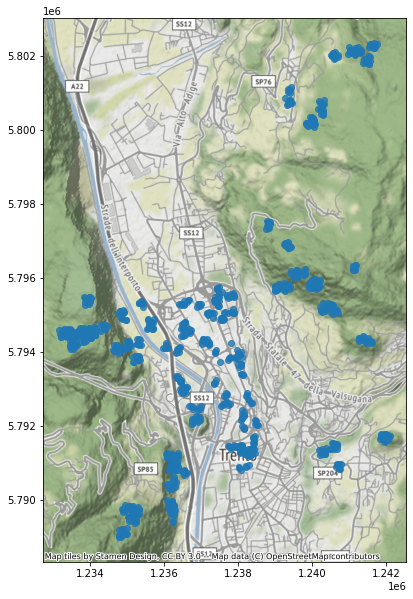

In [12]:
df_wm = points_gdf.set_crs(4326).to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.8)
cx.add_basemap(ax)

### Write to file

In [13]:
points_gdf.to_file("urban_forest_points.geojson", driver="GeoJSON")